## Project 5 - Forecasting Product Demand

### 1) Data cleaning and Feature Engineering
In this notebook, we will look at historical data of various product's sales by date. Also included in this dataset are the warehouse the product is shipped from and the category for a specific product. The first step is to read in the data.

In [227]:
import numpy as np
import pandas as pd

original = pd.read_csv("../data/Historical Product Demand.csv")
print(original.head(5))

#we can drop the rows that don't have a date- these happen to be the only rows with NaN. It's okay to just drop them because 
#they represent only ~1% of the data set and the associated data is useless without the date
original.dropna(inplace=True)


   Product_Code Warehouse Product_Category       Date Order_Demand
0  Product_0993    Whse_J     Category_028  2012/7/27         100 
1  Product_0979    Whse_J     Category_028  2012/1/19         500 
2  Product_0979    Whse_J     Category_028   2012/2/3         500 
3  Product_0979    Whse_J     Category_028   2012/2/9         500 
4  Product_0979    Whse_J     Category_028   2012/3/2         500 


In [228]:
#change the type of the input data to be accessible by the models

original['Date'] = pd.to_datetime(original['Date']) 
original.sort_values(['Date'], inplace=True)

original['Order_Demand'] = original['Order_Demand'].replace('[(]', '-', regex=True).astype('str')
original['Order_Demand'] = original['Order_Demand'].replace('[)]', '', regex=True).astype('int')   

original = original.groupby(['Date', 'Product_Code', 'Warehouse', 'Product_Category'])['Order_Demand'].sum().reset_index()

original.head()

,Date,Product_Code,Warehouse,Product_Category,Order_Demand
0,2011-01-08,Product_0965,Whse_A,Category_006,2
1,2011-05-31,Product_1724,Whse_A,Category_003,108
2,2011-06-24,Product_1521,Whse_S,Category_019,92000
3,2011-09-02,Product_1507,Whse_C,Category_019,1250
4,2011-09-27,Product_0608,Whse_C,Category_001,5


In [229]:
#group by product category
byProdCat = original.groupby(['Date', 'Product_Category'])['Order_Demand'].sum().reset_index()
byProdCat.head()

,Date,Product_Category,Order_Demand
0,2011-01-08,Category_006,2
1,2011-05-31,Category_003,108
2,2011-06-24,Category_019,92000
3,2011-09-02,Category_019,1250
4,2011-09-27,Category_001,28


Next we want to do some exploratory analysis on the data. Since the goal is to do a demand forecast, it would be useful to examine the sales over time  by category. However, there are over 2000 products and over 30 categories, so we will just look at an arbitrary two of them. 

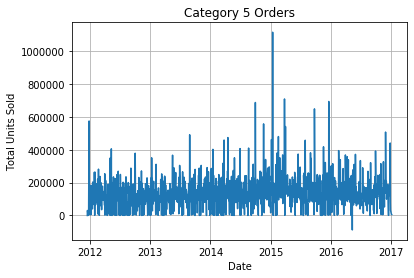

In [230]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

isCat5 = byProdCat['Product_Category'] == 'Category_005'
cat5 = byProdCat[isCat5]
cat5X = cat5['Date']
cat5Y = cat5['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat5X, cat5Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 5 Orders')
ax.grid()
plt.show()

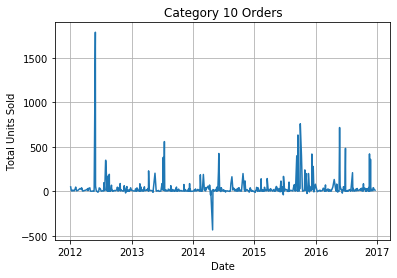

In [231]:
isCat10 = byProdCat['Product_Category'] == 'Category_010'
cat10 = byProdCat[isCat10]
cat10X = cat10['Date']
cat10Y = cat10['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(cat10X, cat10Y)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Category 10 Orders')
ax.grid()
plt.show()

It appears that there is strong fluctation in Category 10, with a severe outlier in 2012. However, category 5 has much more consistent order quantity, with several outliers throughout. A takeaway from these charts is that it could be useful to cut out the extreme outliers, say any data 2 standard deviations away from the mean. However, we won't do that here to remain in the scope of the project time-wise.

What we do need to do is modify the date, as the models can not train with date times. Therefore, we will break the date up into three columns: day, month, and year. Also, we want to include a days since first date. We also need to convert product category, product code, and warehouse to numeric values. We can use regular expressions to change the product category and product codes to ints and label encoding to modify the warehouse values.

In [232]:
import datetime
from sklearn import preprocessing

original['year'] = pd.DatetimeIndex(original['Date']).year
original['month'] = pd.DatetimeIndex(original['Date']).month
original['day'] = pd.DatetimeIndex(original['Date']).day

date = original.iloc[0]['Date']
original['daysSinceFirst'] = (original['Date'] - date).dt.days
original['Product_Code'] = original['Product_Code'].replace('[Product_]', '', regex=True).astype('int') 
original['Product_Category'] = original['Product_Category'].replace('[Category_]', '', regex=True).astype('int')  

# Create a label (category) encoder object
le = preprocessing.LabelEncoder()
# Fit the encoder to the pandas column
le.fit(original['Warehouse'])
original['Warehouse'] = le.transform(original['Warehouse'])


#index with timestamp
timeIndex = original.set_index('Date')
timeIndex.drop(columns=['year', 'month', 'day'], inplace = True)
original = original.set_index('Date')
original.head()

,Product_Code,Warehouse,Product_Category,Order_Demand,year,month,day,daysSinceFirst
Date,,,,,,,,
2011-01-08,965,0,6,2,2011,1,8,0
2011-05-31,1724,0,3,108,2011,5,31,143
2011-06-24,1521,3,19,92000,2011,6,24,167
2011-09-02,1507,1,19,1250,2011,9,2,237
2011-09-27,608,1,1,5,2011,9,27,262


Split data up for training / testing. Take the first 5 years of dates for training, then use the final year for testing. We want to test the last dates in the dataset because our forecasting would be for the future, rather than being interspersed with known values. The reason we aren't doing 80/20 here is because I want to test the seasonality capability. If we only had test data for June - Dec, we woulnd't be able to test how the model does in the new year. The difficulty here is that we are splitting the entire data set, rather than splitting at a product level. What I mean is that we could potentially have a new product that starts shipping at the end of our test data that the model has never seen before. This issue will be addressed later when we build a model for a specific product.

It should be noted that I have a dataset with the date only included in the index (timeIndex) and the other with date as the index as well as the date broken up into various other feature columns. I want to see if there's a difference in the outcome.

Since the date range is Jan 2011 - Jan 2017, we will use any dates starting in 2016 as test data.

In [233]:
is_post2016 = original['year'] >= 2016
isNot_post2016 = original['year'] < 2016

timeFeatures_Train = original[is_post2016]
timeFeatures_Test = original[isNot_post2016]

timeIndex_Train = timeIndex[:'2015-12-31']
timeIndex_Test = timeIndex['2016-01-01':]

In [234]:
#split training data into X and Y
timeFeatures_train_Y = timeFeatures_Train['Order_Demand']
timeFeatures_train_X = timeFeatures_Train[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category', 'Warehouse', 'Product_Code']]
#split testing data into X and Y
timeFeatures_test_Y = timeFeatures_Test['Order_Demand']
timeFeatures_test_X = timeFeatures_Test[['year', 'month', 'day', 'daysSinceFirst', 'Product_Category', 'Warehouse', 'Product_Code']]

#split training data into X and Y
timeIndex_train_Y = timeIndex_Train['Order_Demand']
timeIndex_train_X = timeIndex_Train[['Product_Category', 'Warehouse', 'Product_Code']]
#split testing data into X and Y
timeIndex_test_Y = timeIndex_Test['Order_Demand']
timeIndex_test_X = timeIndex_Test[['Product_Category', 'Warehouse', 'Product_Code']]

### 2) Build Models

First we start with a GradientBoostingRegressor. This model is essentially a collection of weak learners that when combined, make a strong learning model. The reason I'm using it is because it's generally fast and very accurate. Observe that for each, we test with a different learning rate. The learning rate reduces the contribution of each tree in the model.

In [235]:
from sklearn.ensemble import GradientBoostingRegressor

lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(timeFeatures_train_X, timeFeatures_train_Y)

    if (learning_rate == .25):
        predictionGBR_TF = gb_clf.predict(timeFeatures_test_X)
        
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(timeFeatures_train_X, timeFeatures_train_Y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(timeFeatures_test_X, timeFeatures_test_Y)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.331
Accuracy score (validation): 0.285
 
Learning rate:  0.075
Accuracy score (training): 0.370
Accuracy score (validation): 0.316
 
Learning rate:  0.1
Accuracy score (training): 0.386
Accuracy score (validation): 0.327
 
Learning rate:  0.25
Accuracy score (training): 0.438
Accuracy score (validation): 0.351
 
Learning rate:  0.5
Accuracy score (training): 0.464
Accuracy score (validation): 0.234
 
Learning rate:  0.75
Accuracy score (training): 0.470
Accuracy score (validation): 0.137
 
Learning rate:  1
Accuracy score (training): 0.475
Accuracy score (validation): -0.165
 


In [236]:
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(timeIndex_train_X, timeIndex_train_Y)

    if (learning_rate == 1):
        predictionGBR_TI = gb_clf.predict(timeIndex_test_X)
        
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(timeIndex_train_X, timeIndex_train_Y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(timeIndex_test_X, timeIndex_test_Y)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.285
Accuracy score (validation): 0.306
 
Learning rate:  0.075
Accuracy score (training): 0.317
Accuracy score (validation): 0.333
 
Learning rate:  0.1
Accuracy score (training): 0.333
Accuracy score (validation): 0.353
 
Learning rate:  0.25
Accuracy score (training): 0.382
Accuracy score (validation): 0.397
 
Learning rate:  0.5
Accuracy score (training): 0.394
Accuracy score (validation): 0.414
 
Learning rate:  0.75
Accuracy score (training): 0.403
Accuracy score (validation): 0.422
 
Learning rate:  1
Accuracy score (training): 0.404
Accuracy score (validation): 0.424
 


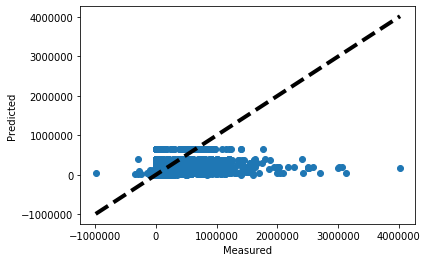

In [237]:
predGBR_TF = pd.DataFrame(data=predictionGBR_TF.flatten())

fig, ax = plt.subplots()
ax.scatter(timeFeatures_test_Y, predGBR_TF)
ax.plot([timeFeatures_test_Y.min(), timeFeatures_test_Y.max()], [timeFeatures_test_Y.min(), timeFeatures_test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

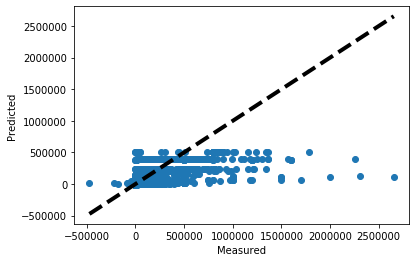

In [238]:

predGBR_TI = pd.DataFrame(data=predictionGBR_TI.flatten())

fig, ax = plt.subplots()
ax.scatter(timeIndex_test_Y, predGBR_TI)
ax.plot([timeIndex_test_Y.min(), timeIndex_test_Y.max()], [timeIndex_test_Y.min(), timeIndex_test_Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

The two methods of indexing date performed very similarly, so let's use the one with the date as an index and as multiple features. It should be noted that the plots above correspond to the best performing learning rate of each respective model. The reason we employed a plot of measured vs predicted vs a time series plot is because we're predicting a very high quantity of products, so a plot of all products could be quite difficult to visualize. The line included on these graphs represents the "perfect predictor" line. 

One reason that we have some outlier points on the measured (x) axis is because they were several standard deviations from the mean and rare or non-existent in the training set, so they were difficult to predict.

I hypothesize that it might be better to predict by product and ignore many of the datasets which are simply impossible to predict (i.e. a single spike or similar). One way to bin these quantitatively is to train a model for each product, then select the best performing ones. However, this is highly inefficient and time consuming. Therefore, we can proxy this by hypothesizing that we will be able to best predict order_demand for products which have a low standard-deviation to mean ratio, also known as the coefficient of variation. In the real world, we'd want to ignore products that have below a certain amount of orders shipped (if they shipped on under 100 days for example, ignore that product). For now, due to the 10-hour rule, we will simply inspect a couple to generate models on.

In [239]:
means = original.groupby(['Product_Code'])['Order_Demand'].mean().reset_index()
stdevs = original.groupby(['Product_Code'])['Order_Demand'].std().reset_index()

ratio = pd.DataFrame(columns=['Product_Code', 'ratio'])
ratio['Product_Code'] = stdevs['Product_Code']
ratio['ratio'] = stdevs['Order_Demand'] / means['Order_Demand']

#sort by ratio
ratio.sort_values(['ratio'], inplace=True)

ratio.head(50)


,Product_Code,ratio
1687,1698,0.000000
1037,1048,0.096328
1306,1317,0.124935
1568,1579,0.134697
2029,2042,0.174331
2031,2044,0.176170
66,67,0.177924
2034,2047,0.193542
1351,1362,0.214270
2035,2048,0.230050


Now that we have the products with the lowest coefficient of variation, let's choose one to plot. We want to find a one that ships orders on quite a few dates, which we will do by inspection here. Product 1513 meets the criteria. Of course, for production we'd want to do a much more rigorous analysis, but this is simply a proof of concept.

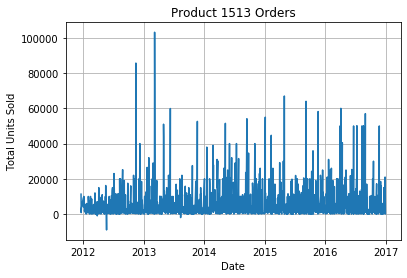

In [240]:
byProd = timeIndex.groupby(['Date', 'Product_Code', 'Warehouse'])['Order_Demand'].sum().reset_index()
byProd = byProd.set_index('Date')

is1513 = byProd['Product_Code'] == 1513
prod = byProd[is1513]
prodX = prod.index
prodY = prod['Order_Demand']

# Data for plotting

fig, ax = plt.subplots()
ax.plot(prodX, prodY)

ax.set(xlabel='Date', ylabel='Total Units Sold',
       title='Product 1513 Orders')
ax.grid()
plt.show()

Observe that outliers are not too common, specifically those above 60,000 units sold. Next we prepare the data to be trained on some models.

In [241]:
byProdTF = original.groupby(['Date', 'year', 'day', 'month', 'daysSinceFirst', 'Product_Code', 'Warehouse'])['Order_Demand'].sum().reset_index()
byProdTF = byProdTF.set_index('Date')

is1513 = byProd['Product_Code'] == 1513
prod1513TF = byProdTF[is1513]

prod_Train = prod1513TF[:'2015-12-31']
prod_Test = prod1513TF['2016-01-01':]


prodTF_train_X = prod_Train[['year', 'day', 'month', 'daysSinceFirst', 'Product_Code', 'Warehouse']]
prodTF_test_X = prod_Test[['year', 'day', 'month', 'daysSinceFirst', 'Product_Code', 'Warehouse']]
prodTF_train_Y = prod_Train['Order_Demand']
prodTF_test_Y = prod_Test['Order_Demand']


print(prodTF_test_X.head())
print(prodTF_test_Y.head())

            year  day  month  daysSinceFirst  Product_Code  Warehouse
Date                                                                 
2016-01-05  2016    5      1            1823          1513          0
2016-01-05  2016    5      1            1823          1513          2
2016-01-06  2016    6      1            1824          1513          0
2016-01-06  2016    6      1            1824          1513          2
2016-01-07  2016    7      1            1825          1513          0
Date
2016-01-05       0
2016-01-05    2000
2016-01-06    2300
2016-01-06    4000
2016-01-07     400
Name: Order_Demand, dtype: int64


In [242]:
#first use the same model used above
lr_list = [0.05, 0.075, 0.1, 0.25, 0.5, 0.75, 1]

for learning_rate in lr_list:
    gb_clf = GradientBoostingRegressor(learning_rate=learning_rate, random_state=0)
    gb_clf.fit(prodTF_train_X, prodTF_train_Y)

    if (learning_rate == .05):
        predictionGBR_prod1513 = gb_clf.predict(prodTF_test_X)
    if (learning_rate == 1):
        predLearningRate1 = gb_clf.predict(prodTF_test_X)
        
    print("Learning rate: ", learning_rate)
    print("Accuracy score (training): {0:.3f}".format(gb_clf.score(prodTF_train_X, prodTF_train_Y)))
    print("Accuracy score (validation): {0:.3f}".format(gb_clf.score(prodTF_test_X, prodTF_test_Y)))
    print(' ')

Learning rate:  0.05
Accuracy score (training): 0.208
Accuracy score (validation): 0.009
 
Learning rate:  0.075
Accuracy score (training): 0.290
Accuracy score (validation): -0.055
 
Learning rate:  0.1
Accuracy score (training): 0.360
Accuracy score (validation): -0.058
 
Learning rate:  0.25
Accuracy score (training): 0.536
Accuracy score (validation): -0.025
 
Learning rate:  0.5
Accuracy score (training): 0.707
Accuracy score (validation): -2.588
 
Learning rate:  0.75
Accuracy score (training): 0.763
Accuracy score (validation): -0.721
 
Learning rate:  1
Accuracy score (training): 0.805
Accuracy score (validation): -3.334
 


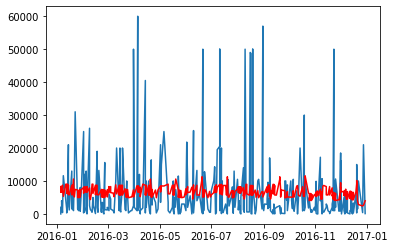

In [243]:
from matplotlib import pyplot
new_series = pd.Series(predictionGBR_prod1513).to_frame()
new_series.set_index(prod_test_Y.index, inplace = True)

pyplot.plot(prod_test_Y)
pyplot.plot(new_series, color='red')
pyplot.show()

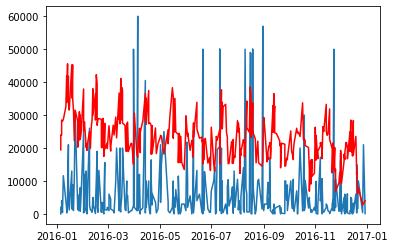

In [244]:
new_series = pd.Series(predLearningRate1).to_frame()
new_series.set_index(prod_test_Y.index, inplace = True)

pyplot.plot(prod_test_Y)
pyplot.plot(new_series, color='red')
pyplot.show()

I plotted two charts for the gradient boosting regressor. The first is the prediction when the model was trained at the lowest tested learning rate (.05), the second at the highest (1). The .05 learning rate hd the highest accuracy, but also was least likely to be influenced by the input data (R^2 closed to 0), but this is easy to reason about because it is likely focusing on the mean of the training data. The higher learning has more variability, hence it's R^2's greater distance from 0, but is less accuracy because of that.

Next, let's attempt a neural network. I have not yet tried one of these, so I'm curious to see how it will work out.

In [245]:
from sklearn.neural_network import MLPRegressor

#use 8 hidden layers with 50 nodes each, maximum number of iterations is 500
mlp2 = MLPRegressor(hidden_layer_sizes = (50,50,50,50,50,50,50,50), max_iter = 500)

mlp2.fit(prodTF_train_X, prodTF_train_Y)

predNN = mlp2.predict(prodTF_test_X)


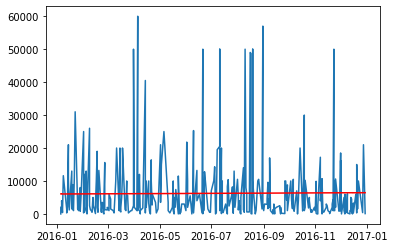

In [246]:
predNNResults = pd.Series(predNN).to_frame()
predNNResults.set_index(prodTF_test_Y.index, inplace = True)

pyplot.plot(prodTF_test_Y)
pyplot.plot(predNNResults, color='red')
pyplot.show()

In [247]:
score = mlp2.score(prodTF_test_X, prodTF_test_Y)
print(score)

-0.0010944090751547897


This model did not live up to the "hype" of neural networks. A near constant prediction over the test set, along with an R^2 score near 0, indicates that barely places weight on the input data. It is predicting very close to the mean of the training set, because we specifically selected this product (1517) because of it's low variance. Therefore, it's reasonable to expect the resulting predictions will reflect that low variance. There are likely parameters that we could tune to improve this model, I only played around with the hidden layer and max_iterations. Unfortunately, time invested in this project has far exceeded the 10 hr limit due to some rewrites, so fine-tuning the neural network will have to be saved for another day.

It should be noted that I attempted to construct a neural network for the entire dataset, as I did with the first GBR, but the result was similar to this neural network model, so I removed the other one, with the hope that a product specific model might be better. Of course, that hope was ill-founded.

### 3) Conclusion

My earlier hypothesis is false: breaking the dataset down by product did not increase accuracy. One explanation could be that product shipments are not independent of each other, so having all the products train together allows interdependence in the model. Of course, it should be kept in mind that I only tested one individual product for POC.

The takeaways from this project were to figure out how to get the most value out of a dataset that has a lot of ways of approaching it. Breaking it down and modifying date features helped, as we showed. Arguably the most important part was identifying products that lacked many outliers, in a way that we could actually predict these. Although we did this mainly by inspection for the sake of time, the discussion that went with that suggested we a method for doing it at scale. And even though this didn't help us get high accuracy for the product-specific models, applying this to the model training on all products (since it performed best) may be a way to improve it further. Due to the 10 hour rule, I will leave this as an exercise for the reader.

In addition to what has already been described, an extension could be exploring the category feature more, such as grouping sales by category to predict them. One advantage to doing this is that products may have interdependence in sales, such as someone buying a toothbrush who also buys toothpaste and both products could be listed in the same category. Another extention would be to group the data, at whatever level (product, category, etc.) by a different time period. We predicted specific days here, but accuracy may improve if we try and predict by month or season.